In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=cdd8bcd236a4926e50df336104c016b36c51aa80954ab3d724ed8ce146d74da9
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [57]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import (
    ArrayType, IntegerType, FloatType, 
    DoubleType, StringType, TimestampType)

from pyspark.sql.functions import (
    sum, col, count, length, size, split,
    udf, when, isnan, explode, array_min,
    array_max, array_distinct, to_timestamp,
    explode, countDistinct, mean, year, month,
    dayofmonth, hour, minute, second, 
    dayofweek, quarter
)

from pyspark.ml.feature import ( 
    Tokenizer, StopWordsRemover, CountVectorizer, 
    OneHotEncoder, Bucketizer, StringIndexer,
    VectorAssembler
)

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

from textstat import textstat

In [4]:
spark = SparkSession \
    .builder \
    .config("spark.driver.memory", "20g") \
    .config("spark.driver.maxResultSize", "10g") \
    .config("spark.jars", "postgresql-42.6.0.jar") \
    .appName("Yelp Review Sense - EDA - Reviews") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/02 20:03:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [36]:
# Define the JDBC connection details
jdbc_url = "jdbc:postgresql://intentionally-removed.amazonaws.com/yelpreviewsense"
db_table = ""
db_user = "postgres"
db_password = ""

# Specify the read options
read_options = {
    "url": jdbc_url,
    "driver": "org.postgresql.Driver",
    "dbtable": f"""
        (SELECT
            review_id,
            business_id,
            user_id,
            review_date,
            review_stars,
            review_text,
            review_total_interaction,
            review_sentiment
        FROM {db_table}) AS review_data
    """,
    "user": db_user,
    "password": db_password,
}

# Read the table into a PySpark DataFrame
df = spark.read.format("jdbc").options(**read_options).load()
df.limit(5).toPandas()

,review_id,business_id,user_id,review_date,review_stars,review_text,review_total_interaction,review_sentiment
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,2018-07-07 22:09:11,3.0,"If you decide to eat here, just be aware it is...",0,0
1,BiTunyQ73aT9WBnpR9DZGw,7ATYjTIgM3jUlt4UM3IypQ,OyoGAe7OKpv6SyGZT5g77Q,2012-01-03 15:28:18,5.0,I've taken a lot of spin classes over the year...,2,1
2,saUsX_uimxRlCVr67Z4Jig,YjUWPpI6HXG530lwP-fb2A,8g_iMtfSiwikVnbP2etR0A,2014-02-05 20:30:30,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0
3,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,2015-01-04 00:01:03,5.0,"Wow! Yummy, different, delicious. Our favo...",2,1
4,Sx8TMOWLNuJBWer-0pcmoA,e4Vwtrqf-wpJfwesgvdgxQ,bcjbaE6dDog4jkNY91ncLQ,2017-01-14 20:54:15,4.0,Cute interior and owner (?) gave us tour of up...,2,1


In [9]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,review_id,business_id,user_id,review_date,review_stars,review_text,review_total_interaction,review_sentiment
0,0,0,0,0,0,0,0,0


In [10]:
# Extracting various text statistics from the review_text column

df = df.withColumn("num_words", size(split(col("review_text"), " "))) \
    .withColumn("num_sentences", size(split(col("review_text"), "[.!?]"))) \
    .withColumn("avg_word_length", length(col("review_text")) / col("num_words")) \
    .withColumn("avg_sentence_length", length(col("review_text")) / col("num_sentences")) \
    .withColumn("num_characters", length(col("review_text"))) \
    .withColumn("num_digits", udf(lambda text: len([word for word in text.split() if word.isdigit()]), IntegerType())(col("review_text"))) \
    .withColumn('num_mentions', F.udf(lambda x: len([x for x in x.split() if x.startswith('@')]), IntegerType())('review_text')) \
    .withColumn('num_hashtags', F.udf(lambda x: len([x for x in x.split() if x.startswith('#')]), IntegerType())('review_text'))

df.limit(5).toPandas()

,review_id,business_id,user_id,review_date,review_stars,review_text,review_total_interaction,review_sentiment,num_words,num_sentences,avg_word_length,avg_sentence_length,num_characters,num_digits,num_mentions,num_hashtags
0,KU_O5udG6zpxOg-VcAEodg,XQfwVwDr-v0ZS3_CbbE5Xw,mh_-eMZ6K5RLWhZyISBhwA,2018-07-07 22:09:11,3.0,"If you decide to eat here, just be aware it is...",0,0,101,8,5.079208,64.125000,513,1,0,0
1,BiTunyQ73aT9WBnpR9DZGw,7ATYjTIgM3jUlt4UM3IypQ,OyoGAe7OKpv6SyGZT5g77Q,2012-01-03 15:28:18,5.0,I've taken a lot of spin classes over the year...,2,1,149,8,5.563758,103.625000,829,0,0,0
2,saUsX_uimxRlCVr67Z4Jig,YjUWPpI6HXG530lwP-fb2A,8g_iMtfSiwikVnbP2etR0A,2014-02-05 20:30:30,3.0,Family diner. Had the buffet. Eclectic assortm...,0,0,55,10,6.163636,33.900000,339,0,0,0
3,AqPFMleE6RsU23_auESxiA,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,2015-01-04 00:01:03,5.0,"Wow! Yummy, different, delicious. Our favo...",2,1,48,12,5.062500,20.250000,243,1,0,0
4,Sx8TMOWLNuJBWer-0pcmoA,e4Vwtrqf-wpJfwesgvdgxQ,bcjbaE6dDog4jkNY91ncLQ,2017-01-14 20:54:15,4.0,Cute interior and owner (?) gave us tour of up...,2,1,94,14,5.680851,38.142857,534,0,0,0


In [11]:
df.describe().toPandas()

,summary,review_id,business_id,user_id,review_stars,review_text,review_total_interaction,review_sentiment,num_words,num_sentences,avg_word_length,avg_sentence_length,num_characters,num_digits,num_mentions,num_hashtags
0,count,6990280,6990280,6990280,6990280,6990280,6990280,6990280,6990280,6990280,6990280,6990280,6990280,6990280,6990280,6990280
1,mean,None,None,None,3.74858374771826,None,2.0097860171552497,0.6701512671881527,105.79662159455701,10.008506812316531,5.431228401467426,56.7532122629005,567.7644364746477,0.4653680539263091,0.0024765817678261814,0.009303919156314197
2,stddev,None,None,None,1.4787045052556802,None,6.196531781851285,0.47015803502284587,98.75492880047369,8.04947961763884,1.1418843956241929,32.247750321419076,527.2578085249016,1.0357096752338013,0.06217797931898737,0.16943054157229032
3,min,---4VcQZzy_vIIifUDqxsg,---kPU91CF4Lq2-WlRu9Lw,---1lKK3aKOuomHnwAkAow,1.0,!\nMilk Bar is poised to overtake Freret St Po...,-3,0,1,1,1.0,0.5,1,0,0,0
4,max,zzzz1ADBqBEVyfX4lGnQ3Q,zzyx5x0Z7xXWWvWnZFuxlQ,zzzUFM4HFe0SFG0bPjntQA,5.0,＼(^o^)／\nThey have a different taste than most...,1182,1,3079,926,883.0,4487.0,5000,63,28,37


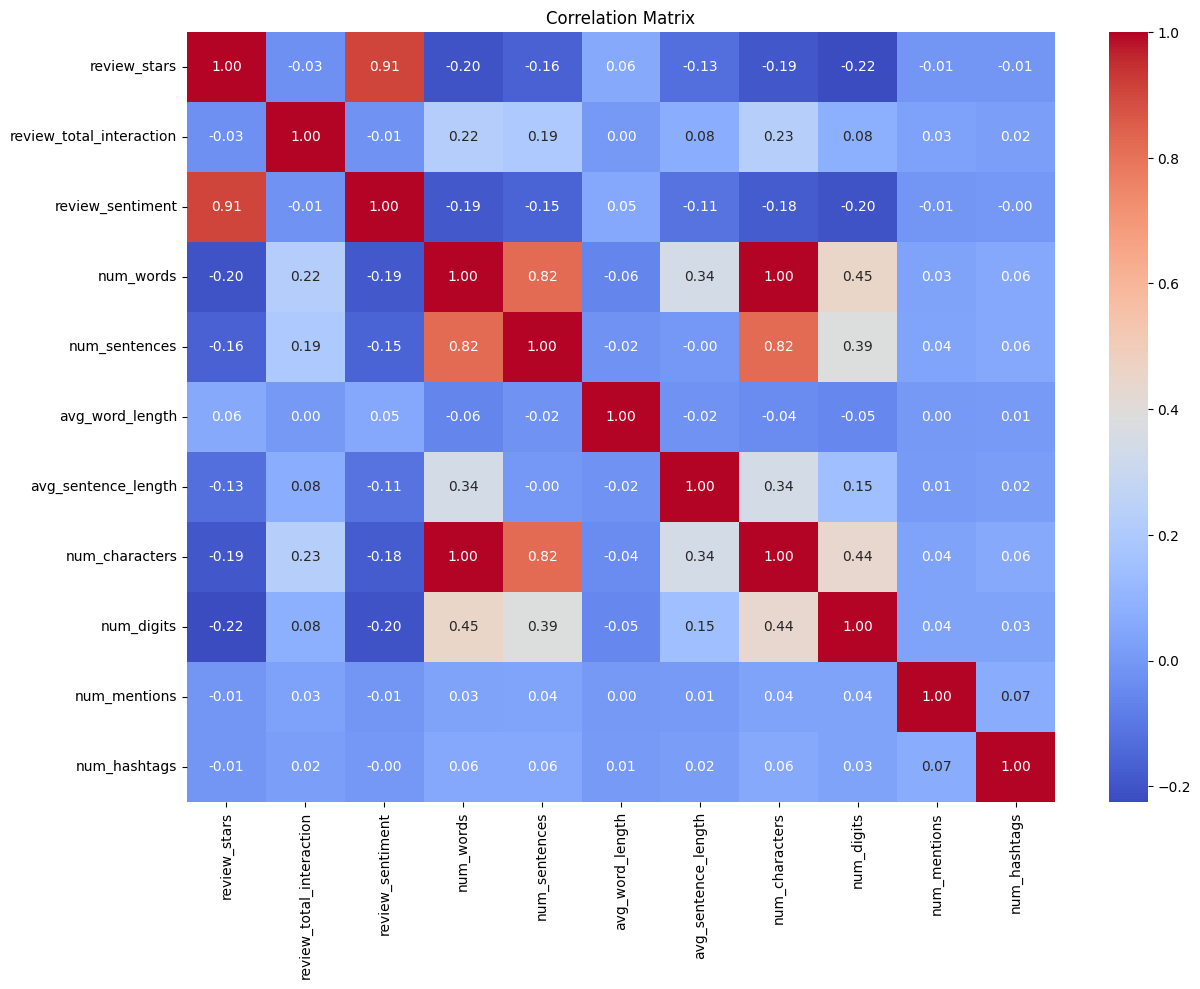

In [12]:
# Correlation matrix

numerical_cols = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'float', 'double']]
correlation_matrix = df.select([col(c).cast("float") for c in numerical_cols]).toPandas().corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The correlation matrix reveals the following:

* The strong positive correlation of 0.91 between 'review_stars' and 'review_sentiment' is consistent with expectations, as 'review_sentiment' is derived from 'review_stars'.

* Additionally, the number of words and sentences in reviews exhibit a strong positive correlation of 0.82, suggesting that longer reviews tend to have more sentences.

* Surprisingly, 'review_stars' shows a negative correlation with 'num_words' (-0.20), implying that shorter reviews may receive higher ratings. 

* The correlation between 'num_mentions' and other features is generally low, suggesting that the presence of mentions in reviews does not strongly correlate with other analyzed aspects

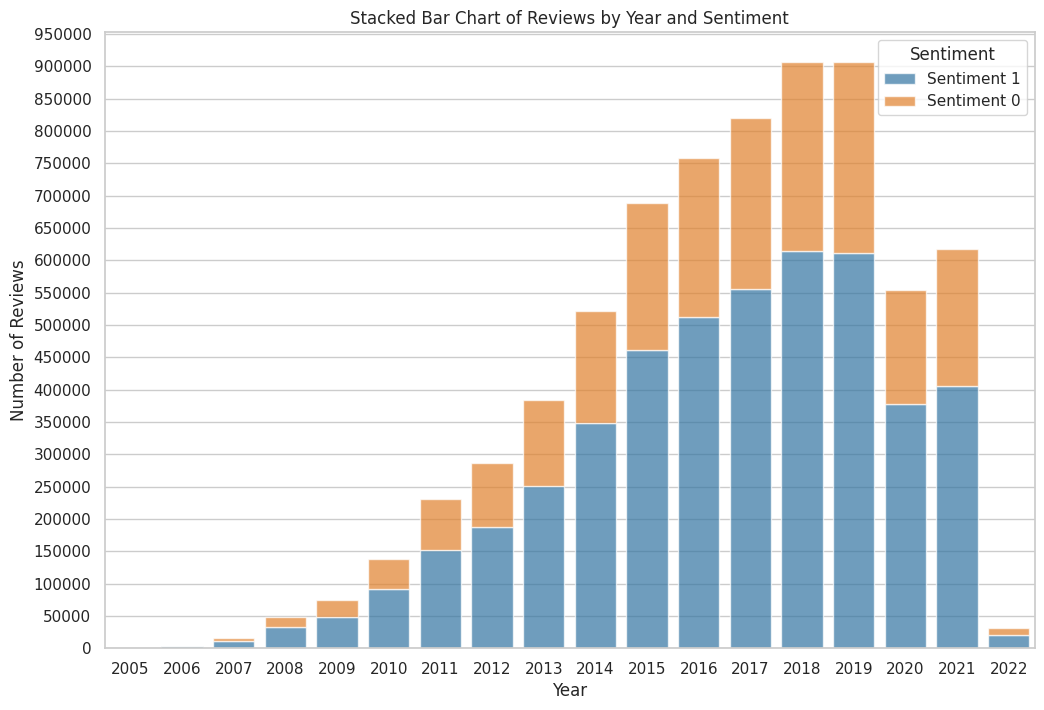

In [13]:
# Visualizing the temporal distribution of sentiment in reviews over the years

temporal_sentiment_df = df.select('review_date', 'review_sentiment' ).toPandas()

temporal_sentiment_df['review_date'] = pd.to_datetime(temporal_sentiment_df['review_date'])
temporal_sentiment_df['year'] = temporal_sentiment_df['review_date'].dt.year
grouped_df = temporal_sentiment_df.groupby(['year', 'review_sentiment']).size().unstack(fill_value=0)

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

sns.barplot(data=grouped_df.reset_index(), x='year', y=1, color='#1f78b4', alpha=0.7, label='Sentiment 1')
sns.barplot(data=grouped_df.reset_index(), x='year', y=0, color='#ff7f0e', alpha=0.7, bottom=grouped_df[1], label='Sentiment 0')

plt.title("Stacked Bar Chart of Reviews by Year and Sentiment")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")

max_value = grouped_df.sum(axis=1).max()
plt.yticks(range(0, max_value + 50000, 50000))

plt.legend(title="Sentiment", loc="upper right")
plt.show()

The stacked bar chart illustrates the temporal distribution of sentiment in reviews over the years:

* The chart showcases a notable increase in the number of both positive and negative sentiments over time. The years 2010 onwards, in particular, exhibit a significant surge in review activity, with a substantial growth in both positive and negative sentiments.

* The positive sentiment consistently outweighs negative sentiment across all years.

* The most recent years, particularly 2018 and 2019, depict a peak in user review activity, suggesting a heightened level of user engagement and diverse sentiment expressions during that period.

* The observed decline in sentiment occurrences during the years 2020 and 2021 may indeed be influenced by the global COVID-19 pandemic.

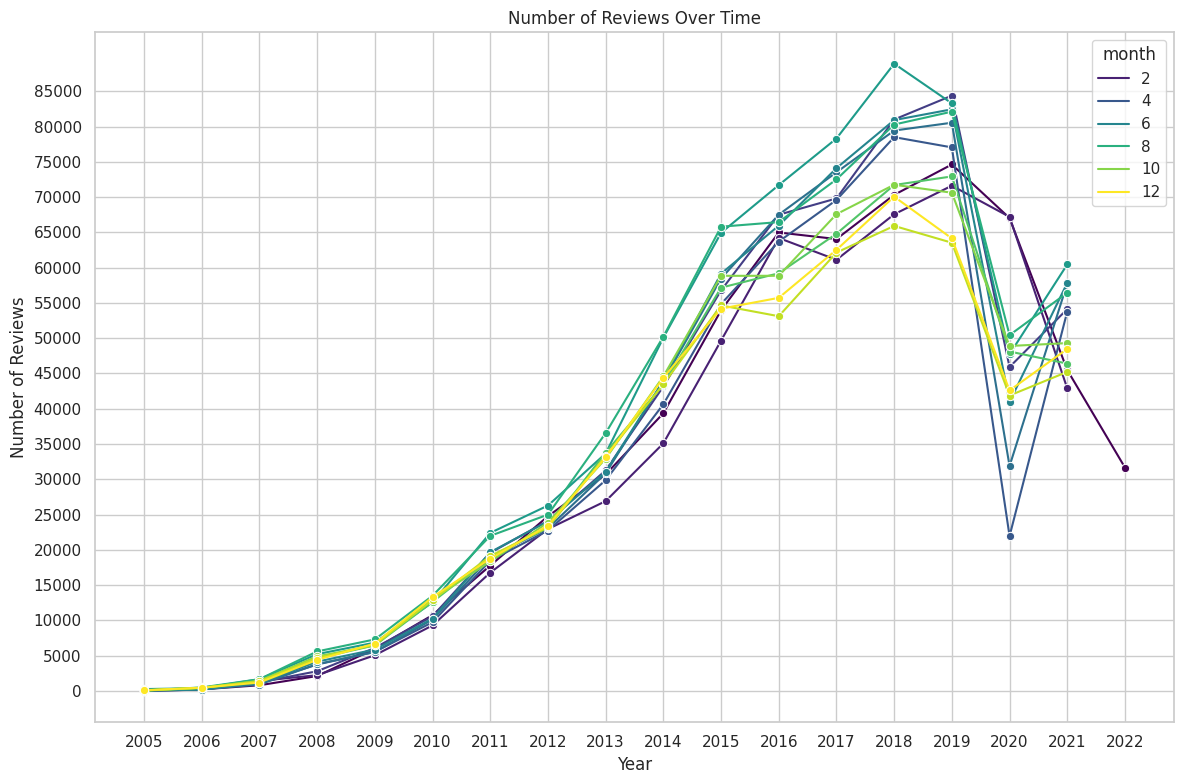

In [14]:
# Visualizing the monthly trends in the number of reviews over the years

temporal_df = df.select("review_date").toPandas()

temporal_df['year'] = temporal_df['review_date'].dt.year
temporal_df['month'] = temporal_df['review_date'].dt.month
temporal_counts = temporal_df.groupby(["year", "month"]).size().reset_index(name='count')

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

sns.lineplot(data=temporal_counts, x="year", y="count", hue="month", marker='o', palette="viridis")
plt.title("Number of Reviews Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.xticks(range(temporal_df['year'].min(), temporal_df['year'].max() + 1))
plt.yticks(range(0, temporal_counts['count'].max() + 1, 5000))

plt.tight_layout()
plt.show()

The above plot illustrates variations in the monthly review counts across different years:

* Generally, the platform experiences peaks and troughs in user engagement throughout the months. For instance, the summer months (June, July, and August) tend to exhibit higher review counts, suggesting increased user activity during vacation periods.

* On the other hand, the winter months (December, January, and February) show varying trends, with a decline in review counts during these months in recent years.

* The decline in reviews during the summer of 2020, particularly in the months of June to August, may be attributed to the broader impact of the COVID-19 pandemic. In March 2020, many states implemented widespread shutdowns and restrictive measures to curb the spread of the virus. The implementation of lockdowns and social distancing measures during the early stages of the pandemic could have led to a decline in user activity, including writing reviews, during the summer months.

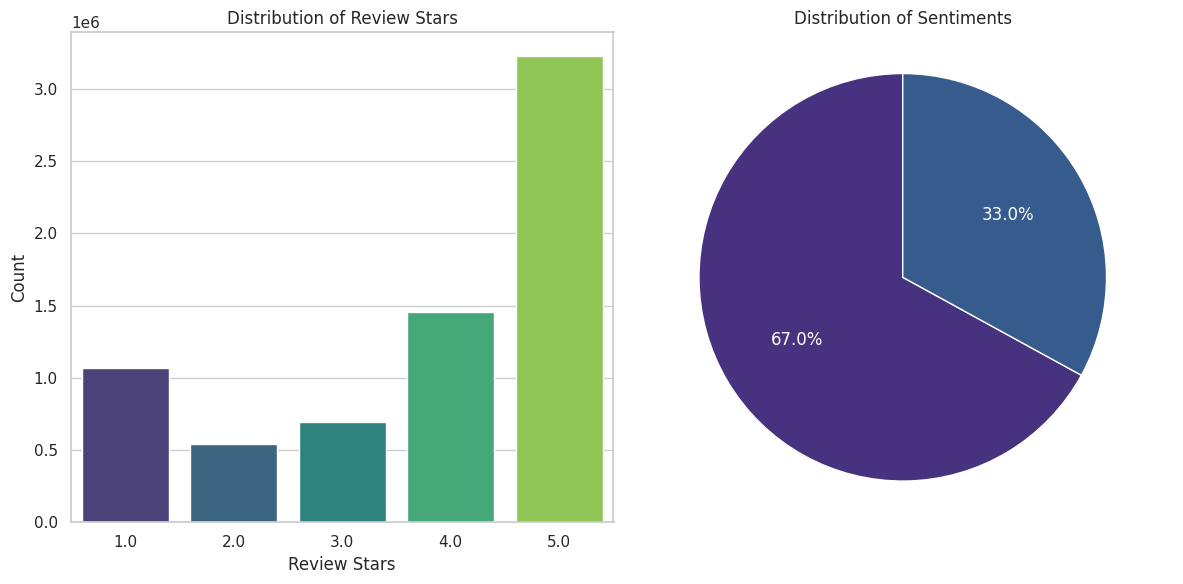

In [15]:
# Analyzing the distribution of review stars and sentiments

review_stars_sentiment_df = df.select('review_stars', 'review_sentiment').toPandas()

sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Distribution of Review Stars
sns.countplot(x='review_stars', data=review_stars_sentiment_df, palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Review Stars')
axes[0].set_xlabel('Review Stars')
axes[0].set_ylabel('Count')

# Plot 2: Pie Chart of Sentiments
sentiment_counts = review_stars_sentiment_df['review_sentiment'].value_counts()
axes[1].pie(sentiment_counts, labels=sentiment_counts.index, autopct='%2.1f%%', textprops={'color': 'white'}, colors=sns.color_palette('viridis'), startangle=90)
axes[1].set_title('Distribution of Sentiments')
axes[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.tight_layout()
plt.show()

While the distribution indicates a dominance of 4 and 5-star ratings, it is intriguing to observe that 1-star reviews are more prevalent than 2 and 3-star ratings. One possible explanation could be that users who have an extremely negative experience are more inclined to express their dissatisfaction through the lowest possible rating. This trend indicates a polarization in user sentiments, with individuals more inclined to either highly praise or strongly criticize, resulting in a lower frequency of moderate 2 and 3-star ratings

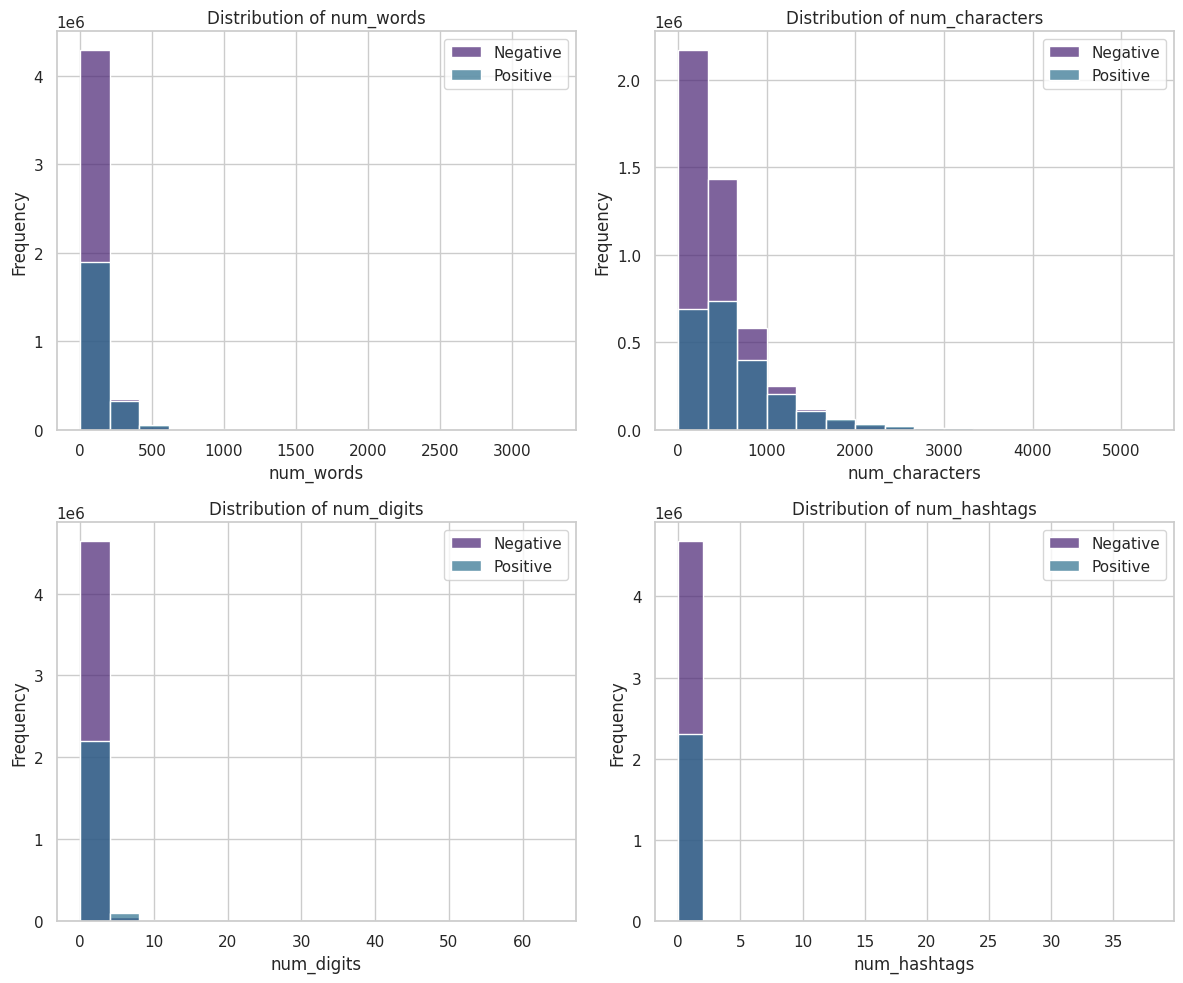

In [39]:
# Exploring the distribution of different text features

selected_columns = ['num_words', 'num_characters', 'num_digits', 'num_hashtags', 'review_sentiment']
text_analysis_df = df.select(selected_columns).toPandas()

sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

axes = axes.flatten()
colors = sns.color_palette("viridis", 10)

for i, column in enumerate(selected_columns[:-1]):
    ax = axes[i]
    sns.histplot(data=text_analysis_df[text_analysis_df['review_sentiment'] == 1], x=column, bins=20, label='Negative', color=colors[0], ax=ax, alpha=0.7, binwidth=max(text_analysis_df[column])//15)
    sns.histplot(data=text_analysis_df[text_analysis_df['review_sentiment'] == 0], x=column, bins=20, label='Positive', color=colors[3], ax=ax, alpha=0.7, binwidth=max(text_analysis_df[column])//15)
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.show()

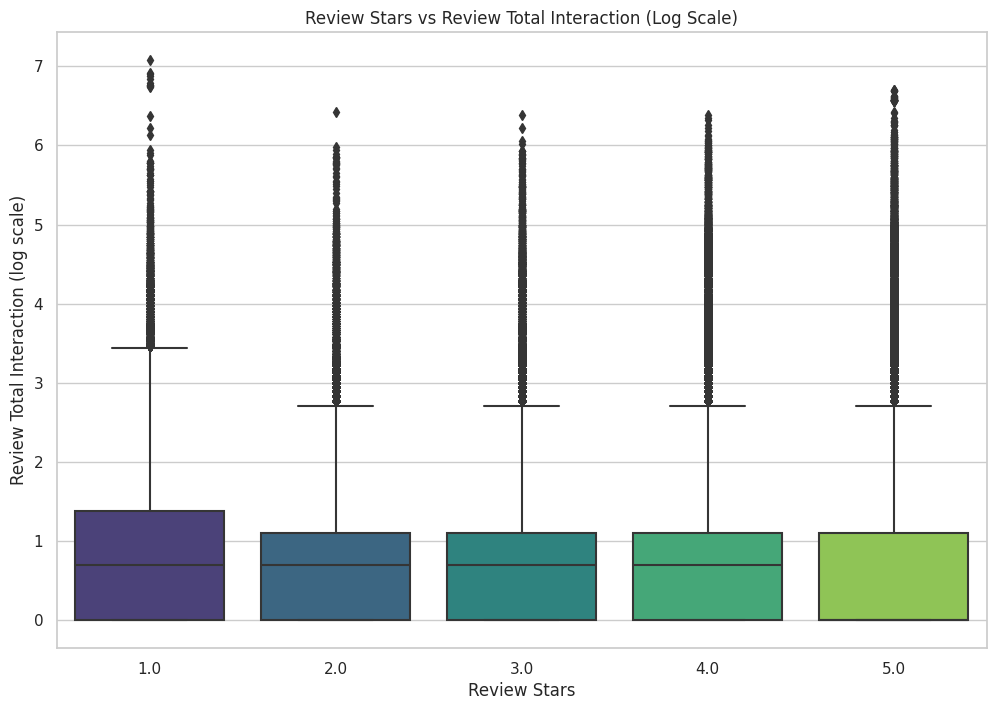

In [26]:
# Investigating the relationship between review stars and the log-transformed total interactions

selected_features = ['review_stars', 'review_total_interaction']
review_interaction_df = df.select(selected_features).toPandas()

review_interaction_df['review_total_interaction'] = np.clip(review_interaction_df['review_total_interaction'], a_min=0, a_max=None)
review_interaction_df['log_review_total_interaction'] = np.log1p(review_interaction_df['review_total_interaction'])

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

sns.boxplot(x='review_stars', y='log_review_total_interaction', data=review_interaction_df, palette='viridis')
plt.title('Review Stars vs Review Total Interaction (Log Scale)')
plt.xlabel('Review Stars')
plt.ylabel('Review Total Interaction (log scale)')

plt.tight_layout()
plt.show()

The box plot comparing 'Review Stars' and the log-transformed 'Review Total Interaction' reveals the following:

* On average, as the review stars increase, there is a slight decrease in the logarithmically transformed review total interaction.

* Notably, 1-star reviews exhibit a higher median log-transformed interaction value compared to higher-star reviews, indicating a potential inverse relationship between star ratings and the log-transformed interaction metric. This suggests that, despite lower star ratings, 1-star reviews may attract relatively higher levels of total interactions.

* The interquartile ranges (IQR) also demonstrate variability in interaction, with 1-star reviews exhibiting the widest IQR and 5-star reviews having the narrowest. 

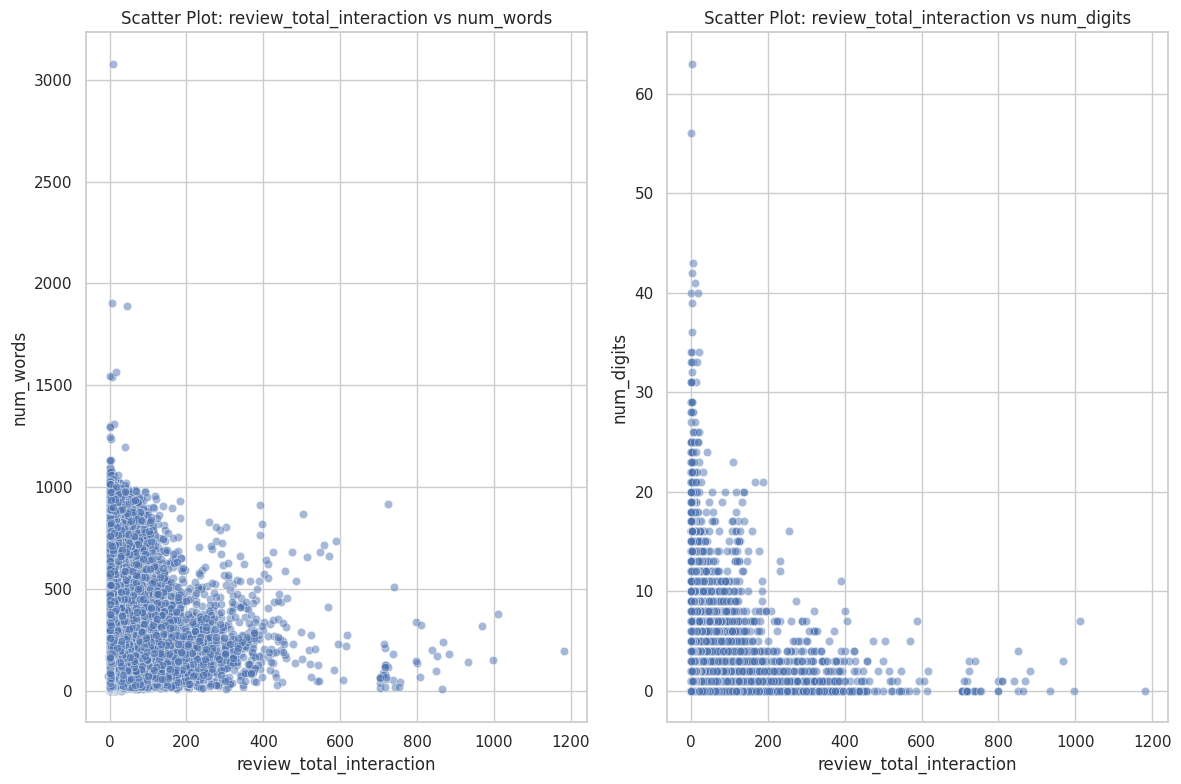

In [40]:
# Exploring the relationships of review_total_interaction with num_words and num_digits

selected_features = ['review_total_interaction', 'num_words', 'num_digits']
review_interaction_df = df.select(selected_features).toPandas()

sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

# Subplot 1: review_total_interaction vs num_words
sns.scatterplot(data=review_interaction_df, x='review_total_interaction', y='num_words', alpha=0.5, ax=axes[0])
axes[0].set_title('Scatter Plot: review_total_interaction vs num_words')

# Subplot 2: review_total_interaction vs num_digits
sns.scatterplot(data=review_interaction_df, x='review_total_interaction', y='num_digits', alpha=0.5, ax=axes[1])
axes[1].set_title('Scatter Plot: review_total_interaction vs num_digits')

plt.tight_layout()
plt.show()

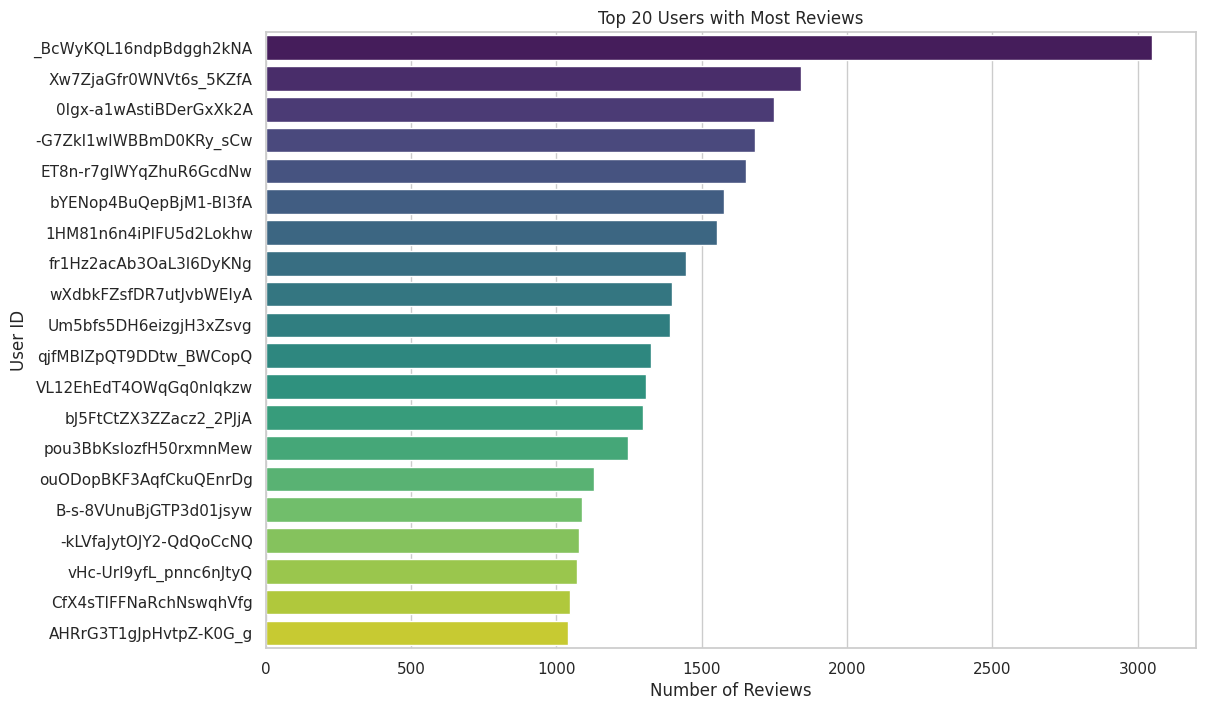

In [41]:
# Visualizing the top 20 users with the highest review counts

user_review_counts = df.groupBy('user_id').count().orderBy('count', ascending=False).toPandas()
top_20_users = user_review_counts.head(20)

sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

sns.barplot(x='count', y='user_id', data=top_20_users, palette='viridis')
plt.title('Top 20 Users with Most Reviews')
plt.xlabel('Number of Reviews')
plt.ylabel('User ID')

plt.tight_layout()
plt.show()

The analysis of the top reviewers reveals a common trend where top users have typically contributed over a thousand reviews. However, a standout observation is the reviewer with the user ID "_BcWyKQL16ndpBdggh2kNA," who has remarkably surpassed this threshold by submitting an extraordinary 3048 reviews. Exploring the content and characteristics of reviews from such users could provide deeper insights into their impact and the diverse perspectives they bring to the platform.

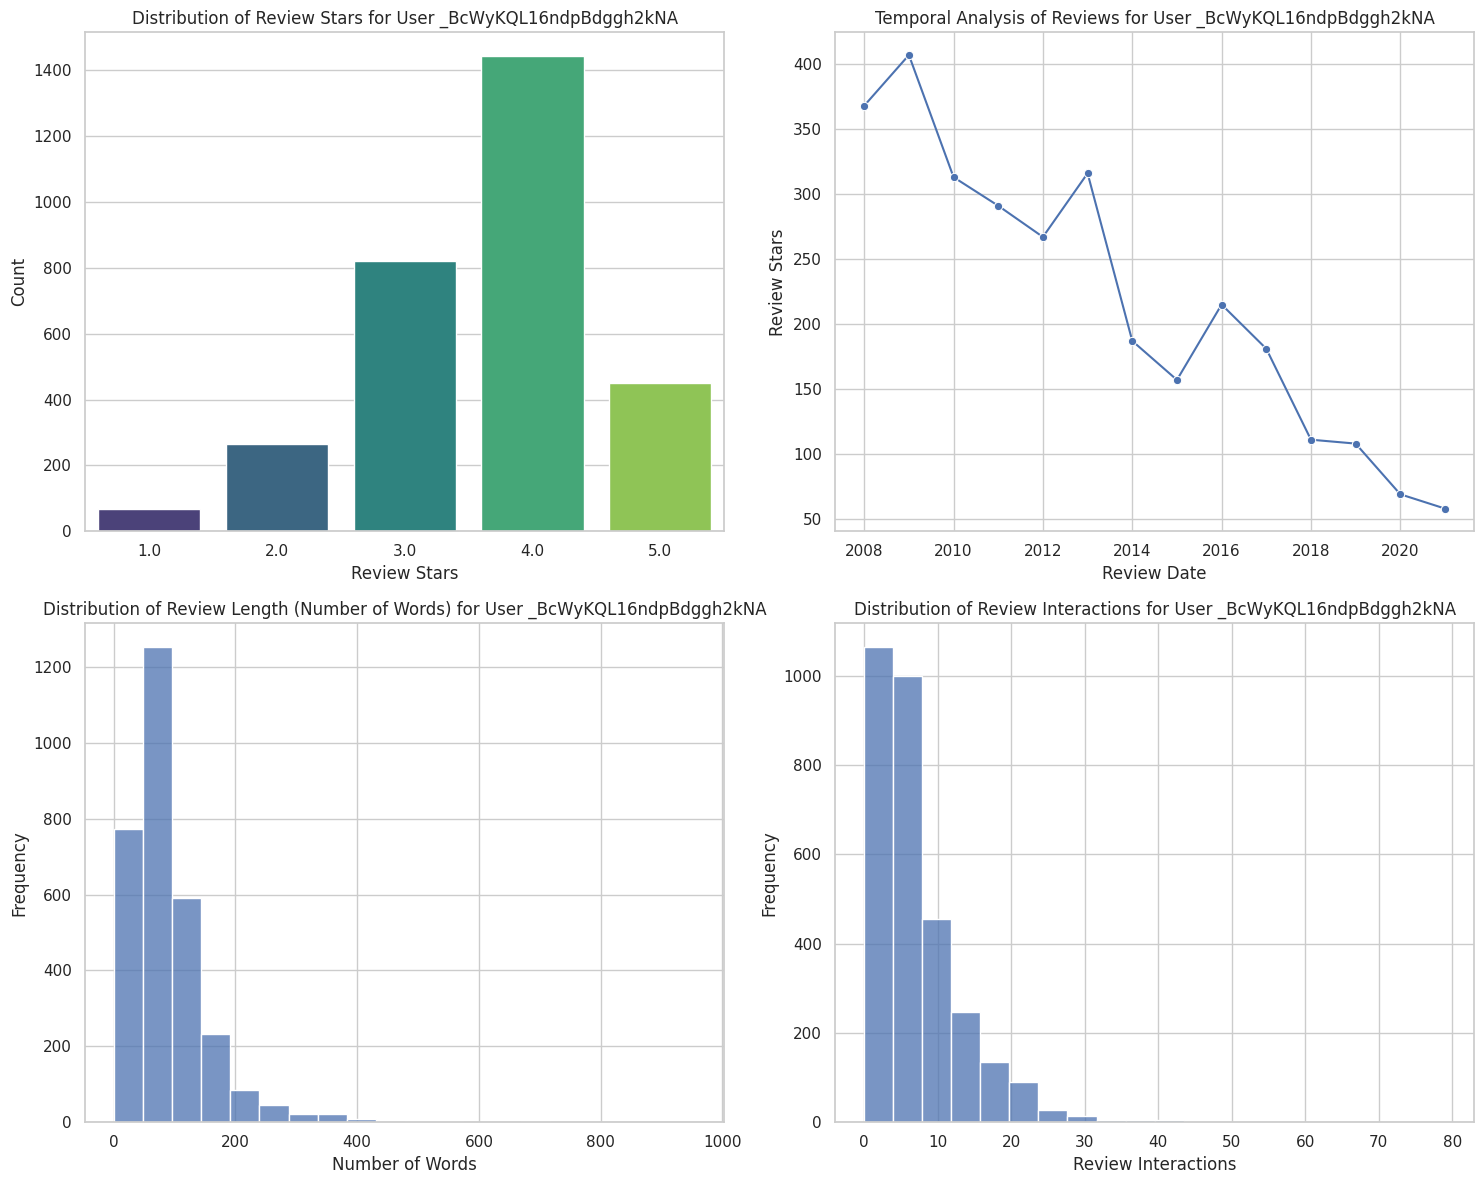

In [42]:
# Analyzing key aspects of the user with the most reviews on the platform

user_id = "_BcWyKQL16ndpBdggh2kNA"
most_review_user_df = df.filter(df.user_id == user_id).toPandas()

sns.set_style("whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))

# Plot 1: Distribution of Review Stars
sns.countplot(x='review_stars', data=most_review_user_df, palette='viridis', ax=axes[0, 0])
axes[0, 0].set_title(f'Distribution of Review Stars for User {user_id}')
axes[0, 0].set_xlabel('Review Stars')
axes[0, 0].set_ylabel('Count')

# Plot 2: Temporal Analysis of Reviews
most_review_user_df['review_year'] = most_review_user_df['review_date'].dt.year
yearly_count = most_review_user_df.groupby('review_year').count()
sns.lineplot(x=yearly_count.index, y='review_stars', data=yearly_count, marker='o', ax=axes[0, 1])
axes[0, 1].set_title(f'Temporal Analysis of Reviews for User {user_id}')
axes[0, 1].set_xlabel('Review Date')
axes[0, 1].set_ylabel('Review Stars')

# Plot 3: Distribution of Review Length (Number of Words)
sns.histplot(most_review_user_df['num_words'], bins=20, ax=axes[1, 0])
axes[1, 0].set_title(f'Distribution of Review Length (Number of Words) for User {user_id}')
axes[1, 0].set_xlabel('Number of Words')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: Distribution of Review Interactions
sns.histplot(most_review_user_df['review_total_interaction'], bins=20, ax=axes[1, 1])
axes[1, 1].set_title(f'Distribution of Review Interactions for User {user_id}')
axes[1, 1].set_xlabel('Review Interactions')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The detailed analysis of the user with the ID "_BcWyKQL16ndpBdggh2kNA" provides the following insights into their review behavior:

* **Distribution of Review Stars**: The user has submitted reviews across all star ratings, with a majority falling into the 4-star category (1443 reviews), followed by 3-star (821 reviews) and 5-star (451 reviews) ratings. Lower star ratings (1 and 2 stars) have fewer occurrences, indicating a tendency towards positive reviews.

* **Temporal Analysis of Reviews**: Over the years, the user's review activity has fluctuated, peaking around 2008, 2009, and 2010, with a gradual decline in subsequent years

* **Distribution of Review Length (Number of Words)**: The average review length for this user is 91 words, with a standard deviation of 72.5 words. The range of review lengths spans from very short (minimum of 1 word) to more detailed (maximum of 955 words), suggesting diversity in the user's writing styles and review content.

* **Distribution of Review Interactions**: The user's reviews exhibit an average of 6.81 interactions, with a standard deviation of 6.25. Interactions include activities such as likes, comments, or shares. The distribution ranges from minimal interactions (minimum of 0) to more engaging reviews (maximum of 79 interactions), showcasing variability in the level of user engagement with the user's content.

In [66]:
# Identifying Key Features Influencing Review Star Ratings

columns_to_drop = ['review_text', 'review_id', 'review_stars']
df = df.drop(*columns_to_drop)

# Create a new column 'top_user' with binary values to indicate if a user is one of the top reviewing users
top_users = df.groupBy("user_id").count().orderBy(F.desc("count")).limit(1000)
top_user_ids = [row["user_id"] for row in top_users.collect()]
df = df.withColumn("top_user", F.when(df["user_id"].isin(top_user_ids), 1).otherwise(0))

# Create a new column 'top_business' with binary values to indicate if the business is one of the top reviewed businesses
top_businesses = df.groupBy("business_id").count().orderBy(F.desc("count")).limit(1000)
top_business_ids = [row["business_id"] for row in top_businesses.collect()]
df = df.withColumn("top_business", F.when(df["business_id"].isin(top_business_ids), 1).otherwise(0))

columns_to_drop = ['business_id', 'user_id']
df = df.drop(*columns_to_drop)

# Add temporal features
df = df.withColumn("year", year("review_date")) \
    .withColumn("month", month("review_date")) \
    .withColumn("day", dayofmonth("review_date")) \
    .withColumn("hour", hour("review_date")) \
    .withColumn("minute", minute("review_date")) \
    .withColumn("second", second("review_date")) \
    .withColumn("day_of_week", dayofweek("review_date")) \
    .withColumn("quarter", quarter("review_date")) \
    .withColumn("day_of_month", dayofmonth("review_date"))

# Create bins for additional features with adjusted bin sizes
num_words_bins = [0, 50, 100, 150, 200, float('inf')]
num_digits_bins = [0, 5, 10, float('inf')]
num_characters_bins = [0, 300, 600, 900, 1200, float('inf')]

df = df.withColumn("num_words_bin", F.when(F.col("num_words").isNull(), None).otherwise(
    F.when(F.col("num_words") <= num_words_bins[0], 0)
    .when((F.col("num_words") > num_words_bins[0]) & (F.col("num_words") <= num_words_bins[1]), 1)
    .when((F.col("num_words") > num_words_bins[1]) & (F.col("num_words") <= num_words_bins[2]), 2)
    .when((F.col("num_words") > num_words_bins[2]) & (F.col("num_words") <= num_words_bins[3]), 3)
    .when((F.col("num_words") > num_words_bins[3]) & (F.col("num_words") <= num_words_bins[4]), 4)
    .otherwise(5)
))

df = df.withColumn("num_digits_bin", F.when(F.col("num_digits").isNull(), None).otherwise(
    F.when(F.col("num_digits") <= num_digits_bins[0], 0)
    .when((F.col("num_digits") > num_digits_bins[0]) & (F.col("num_digits") <= num_digits_bins[1]), 1)
    .when((F.col("num_digits") > num_digits_bins[1]) & (F.col("num_digits") <= num_digits_bins[2]), 2)
    .otherwise(3)
))

df = df.withColumn("num_characters_bin", F.when(F.col("num_characters").isNull(), None).otherwise(
    F.when(F.col("num_characters") <= num_characters_bins[0], 0)
    .when((F.col("num_characters") > num_characters_bins[0]) & (F.col("num_characters") <= num_characters_bins[1]), 1)
    .when((F.col("num_characters") > num_characters_bins[1]) & (F.col("num_characters") <= num_characters_bins[2]), 2)
    .when((F.col("num_characters") > num_characters_bins[2]) & (F.col("num_characters") <= num_characters_bins[3]), 3)
    .when((F.col("num_characters") > num_characters_bins[3]) & (F.col("num_characters") <= num_characters_bins[4]), 4)
    .otherwise(5)
))

feature_columns = ["year", "month", "day", "hour", "minute", "second", "day_of_week", "quarter", "day_of_month",
                   "num_words", "num_sentences", "avg_word_length", "avg_sentence_length", "num_characters",
                   "num_digits", "num_mentions", "num_hashtags", "top_user", "top_business", "num_words_bin",
                   "num_digits_bin", "num_characters_bin"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

# Split the data into training and testing sets and train a Random Forest classifier
(training_data, testing_data) = df_assembled.randomSplit([0.8, 0.2], seed=42)

rf = RandomForestClassifier(labelCol="review_sentiment", featuresCol="features", numTrees=100, seed=42)
model = rf.fit(training_data)

# Evaluate the model on the validation data
evaluator = BinaryClassificationEvaluator(labelCol="review_sentiment", metricName="areaUnderROC")
validation_metric = evaluator.evaluate(model.transform(testing_data))
print(f"Validation Area Under ROC: {validation_metric}")

Validation Area Under ROC: 0.655852304806983


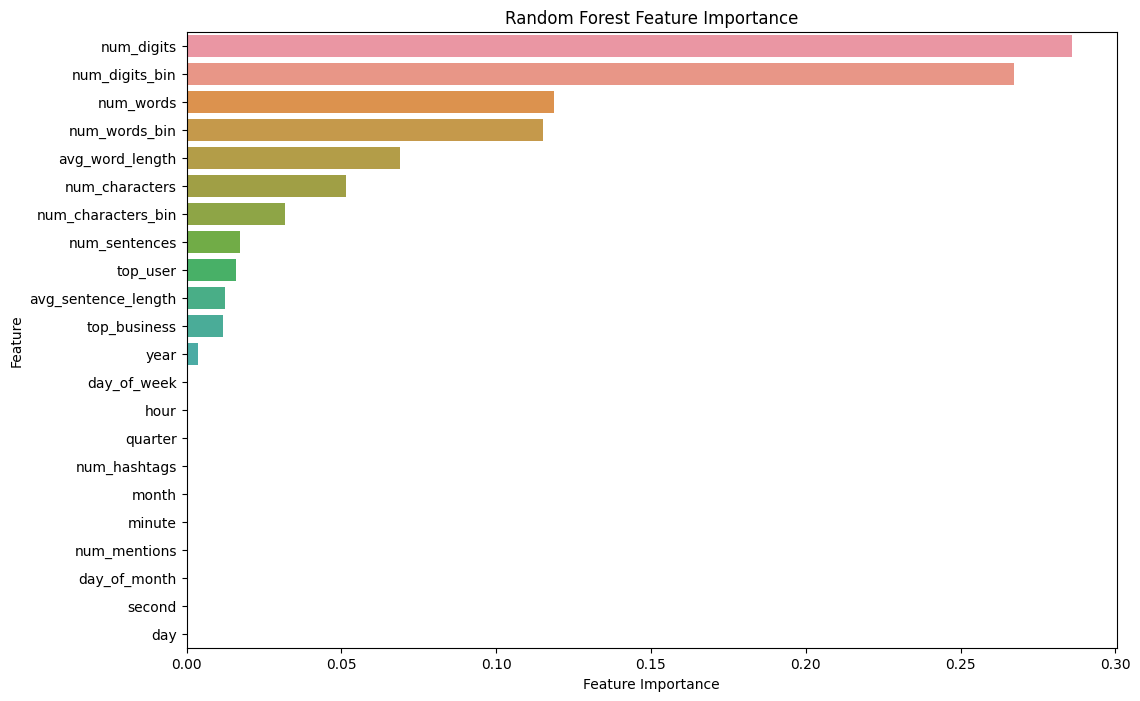

In [64]:
# Get feature importances
feature_importances = model.featureImportances.toArray()

feature_importance_df = pd.DataFrame({'Feature': feature_columns, 'Importance': feature_importances})
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False), orient='h')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

An AUC-ROC of 0.65 suggests that the model performs slightly better than random chance. Given that the model's predictive capability, as indicated by the AUC-ROC, is not very high, the relevance of feature importance in predicting review sentiment may be limited.